In [77]:
import os
import shutil
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from datetime import *
import datetime as dt
from datetime import datetime as dte
from tqdm import tqdm
from matplotlib.backends.backend_pdf import PdfPages

from xgboost import XGBRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import FeatureUnion
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import mean_squared_error,confusion_matrix, r2_score, mean_absolute_error
from scipy import stats
from sklearn.metrics import mean_absolute_error as mae

import re
import sqlalchemy as sa
import json
import joblib

from wordcloud import WordCloud
from sklearn.model_selection import train_test_split



In [78]:
pd.options.display.max_rows = 500
pd.options.display.max_seq_items = 500
pd.options.display.max_categories = 500
pd.set_option("display.max_rows", None)

# Execution Time

In [79]:
print(f'Execution Time = {dt.datetime.now()}')

Execution Time = 2022-11-14 23:08:48.506552


In [80]:
inject_params_dict = ""

# inject_params_dict = {'program_name':'Box3d','mode':'predict','target':'revenue',
#                       'current_wd':'C:\\Users\\simranpal.kohli\\AAAAAfiniti\\Personal\\Self_Study\\Projectzzz\\Hashmeet_Friend\\Aman_Project\\Churn_Model'}

### Mode's 
##### 1. retrain
##### 2. retrain_with_gridsearch
##### 3. predict

In [81]:
mode = inject_params_dict['mode']
target = inject_params_dict['target']
program_name = inject_params_dict['program_name']
current_wd = inject_params_dict['current_wd']
print("Run Mode: ",mode)
print("Target Variable: ",target)
print("Program Name: ",program_name)

Run Mode:  predict
Target Variable:  revenue
Program Name:  Box3d


In [82]:
os.chdir(current_wd)
%run Utilities.ipynb

In [83]:
script_run  =  mode    # predict #retrain_with_gridsearch #retrain
target      = target #churn_trueup_mrc_7day
targettype  = 'continuous'

### Retrain:

### Predict:

In [84]:
os.chdir(current_wd)
print(os.getcwd())

C:\Users\simranpal.kohli\AAAAAfiniti\Personal\Self_Study\Projectzzz\Hashmeet_Friend\Aman_Project\Churn_Model


# Configurations Passed:

In [85]:
unique_identifier = ['id'] #list of columns that makeup primary key
smalls_threshold_percent = 1.0 #less <=smalls_threshold_percent binned to small
numeric_correlation_threshold = 0.8
cat_correlation_threshold = 0.80
top_k = 75 #percentage of top features to pick
plot_granularity = 'date' # week, date

In [86]:
# Configurations Print
print('script_run = ' , script_run)
print('target = ' ,     target)
print('targettype = ' , targettype)

script_run =  predict
target =  revenue
targettype =  continuous


In [87]:
prefix = 'best'
Data_Files_ls = os.listdir(f'{os.getcwd()}/{program_name}/Data_Files/')
pkl_file_name = [files for files in Data_Files_ls if files.startswith(prefix)]
last_trained_model_date = pkl_file_name[0].split('.')[0][-10:]
print('Last train model date: ',last_trained_model_date)

Last train model date:  2022_11_14


In [88]:
if script_run in ['retrain','retrain_with_gridsearch']:
    today_trained_model_date = dte.today().strftime('%Y-%m-%d').replace('-','_')
    
    Data_Files_ls = os.listdir(f'{os.getcwd()}/{program_name}/Data_Files/')
    for f in Data_Files_ls:
        if not f.startswith('.'):
            shutil.copyfile(f'{os.getcwd()}/{program_name}/Data_Files/{f}',f'{os.getcwd()}/{program_name}/Data_Files_Old/{f}')
    model_name_new  = program_name +'_'+today_trained_model_date+'_' + target #retrain after 1-2 weeks
    print("Model Name New: ",model_name_new)
    
model_name  = program_name +'_'+last_trained_model_date+'_' + target #retrain after 1-2 weeks
print("Model Name Old: ",model_name)

In [89]:
if script_run in ['retrain','retrain_with_gridsearch']:
    data_raw = pd.read_csv('Dataset/train.csv')
if script_run == 'predict':
    data_raw = pd.read_csv("Dataset/test.csv")
    pred_raw = data_raw.copy()
data_raw.columns = [x.lower() for x in data_raw.columns] 

In [90]:
data_raw.head()

,id,belongs_to_collection,budget,genres,homepage,imdb_id,original_language,original_title,overview,popularity,...,production_countries,release_date,runtime,spoken_languages,status,tagline,title,keywords,cast,crew
0,3001,"[{'id': 34055, 'name': 'Pokémon Collection', '...",0,"[{'id': 12, 'name': 'Adventure'}, {'id': 16, '...",http://www.pokemon.com/us/movies/movie-pokemon...,tt1226251,ja,ディアルガVSパルキアVSダークライ,Ash and friends (this time accompanied by newc...,3.851534,...,"[{'iso_3166_1': 'JP', 'name': 'Japan'}, {'iso_...",7/14/07,90.0,"[{'iso_639_1': 'en', 'name': 'English'}, {'iso...",Released,Somewhere Between Time & Space... A Legend Is ...,Pokémon: The Rise of Darkrai,"[{'id': 11451, 'name': 'pok√©mon'}, {'id': 115...","[{'cast_id': 3, 'character': 'Tonio', 'credit_...","[{'credit_id': '52fe44e7c3a368484e03d683', 'de..."
1,3002,NaN,88000,"[{'id': 27, 'name': 'Horror'}, {'id': 878, 'na...",NaN,tt0051380,en,Attack of the 50 Foot Woman,When an abused wife grows to giant size becaus...,3.559789,...,"[{'iso_3166_1': 'US', 'name': 'United States o...",5/19/58,65.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,A titanic beauty spreads a macabre wave of hor...,Attack of the 50 Foot Woman,"[{'id': 9748, 'name': 'revenge'}, {'id': 9951,...","[{'cast_id': 2, 'character': 'Nancy Fowler Arc...","[{'credit_id': '55807805c3a3685b1300060b', 'de..."
2,3003,NaN,0,"[{'id': 35, 'name': 'Comedy'}, {'id': 10749, '...",NaN,tt0118556,en,Addicted to Love,Good-natured astronomer Sam is devastated when...,8.085194,...,"[{'iso_3166_1': 'US', 'name': 'United States o...",5/23/97,100.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,A Comedy About Lost Loves And Last Laughs,Addicted to Love,"[{'id': 931, 'name': 'jealousy'}, {'id': 9673,...","[{'cast_id': 11, 'character': 'Maggie', 'credi...","[{'credit_id': '52fe4330c3a36847f8041367', 'de..."
3,3004,NaN,6800000,"[{'id': 18, 'name': 'Drama'}, {'id': 10752, 'n...",http://www.sonyclassics.com/incendies/,tt1255953,fr,Incendies,A mother's last wishes send twins Jeanne and S...,8.596012,...,"[{'iso_3166_1': 'CA', 'name': 'Canada'}, {'iso...",9/4/10,130.0,"[{'iso_639_1': 'fr', 'name': 'Français'}, {'is...",Released,The search began at the opening of their mothe...,Incendies,"[{'id': 378, 'name': 'prison'}, {'id': 539, 'n...","[{'cast_id': 6, 'character': 'Nawal', 'credit_...","[{'credit_id': '56478092c3a36826140043af', 'de..."
4,3005,NaN,2000000,"[{'id': 36, 'name': 'History'}, {'id': 99, 'na...",NaN,tt0418753,en,Inside Deep Throat,"In 1972, a seemingly typical shoestring budget...",3.217680,...,"[{'iso_3166_1': 'US', 'name': 'United States o...",2/11/05,92.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,It was filmed in 6 days for 25 thousand dollar...,Inside Deep Throat,"[{'id': 279, 'name': 'usa'}, {'id': 1228, 'nam...","[{'cast_id': 1, 'character': 'Narrator (voice)...","[{'credit_id': '52fe44ce9251416c75041967', 'de..."


In [91]:
data_raw.describe()

,id,budget,popularity,runtime
count,4398.000000,4.398000e+03,4398.000000,4394.000000
mean,5199.500000,2.264929e+07,8.550230,107.622212
std,1269.737571,3.689991e+07,12.209014,21.058290
min,3001.000000,0.000000e+00,0.000001,0.000000
25%,4100.250000,0.000000e+00,3.895186,94.000000
50%,5199.500000,7.450000e+06,7.482242,104.000000
75%,6298.750000,2.800000e+07,10.938524,118.000000
max,7398.000000,2.600000e+08,547.488298,320.000000


## Dropping Features with most NULL counts

In [92]:
NULLsRecords = data_raw.isnull().sum(axis=0)
print(NULLsRecords[NULLsRecords>0])
max(NULLsRecords)

belongs_to_collection    3521
genres                     16
homepage                 2978
overview                   14
poster_path                 1
production_companies      258
production_countries      102
release_date                1
runtime                     4
spoken_languages           42
status                      2
tagline                   863
title                       3
keywords                  393
cast                       13
crew                       22
dtype: int64


3521

In [93]:
data_raw.drop(['belongs_to_collection'], axis=1, inplace=True)
data_raw.drop(['homepage'], axis=1, inplace=True)

# Budget Metric & its Distribution:

In [94]:
data_raw['release_date'] = pd.to_datetime(data_raw['release_date'],errors='coerce')
data_raw['date'] = pd.to_datetime(data_raw['release_date'],errors='coerce')
data_raw['date'] = data_raw['date'].dt.date
data_raw['week'] = data_raw['release_date'].dt.isocalendar().year * 52 + data_raw['release_date'].dt.isocalendar().week

0 records in data where target is NA 



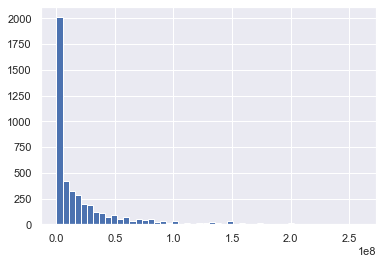

In [95]:
#Data Preprocessing & Distribtuion of Budget Metric
na_target = data_raw[data_raw['budget'].isna()]
if na_target.shape[0]>=0:
    print(f'{na_target.shape[0]} records in data where target is NA \n')
    data_raw = data_raw.dropna(axis = 0, subset=['budget'])        
    %matplotlib inline
    data_raw['budget'].hist(bins=50)
    plt.show()

## Manually Clipping Budget
Make a table with weekwise 1st and 99th quantiles as sanity check for `groupby` operation

In [96]:
weekly_quantiles = data_raw.groupby('week')['budget'].quantile([0.01, 0.99]).reset_index()
weekly_quantiles = weekly_quantiles.pivot(index = 'week', columns = 'level_1').reset_index()
weekly_quantiles.columns = weekly_quantiles.columns.to_flat_index()
weekly_quantiles.columns = [
    'week', 
    'budget' + '_' + str(0.01), 
    'budget' + '_' + str(0.99)
]
weekly_quantiles.head()

,week,budget_0.01,budget_0.99
0,102565,3500000.0,3500000.0
1,102566,130000.0,130000.0
2,102567,1978000.0,1978000.0
3,102572,0.0,0.0
4,102574,2000000.0,2000000.0


In [97]:
def clip_series(s, lower, upper):
    clipped = s.clip(lower = s.quantile(lower), upper = s.quantile(upper))
    return clipped

clipped_target = data_raw.groupby('week')['budget'].apply(clip_series, lower = 0.01, upper = 0.99)

In [98]:
data_raw['clipped_budget'] = clipped_target

In [99]:
# Clipping should not create NAs in target metric
assert data_raw['budget'].isna().sum() == 0

In [100]:
# Examine summary statistics to confirm in and max have been clipped
data_raw[['budget', 'clipped_budget']].describe()

,budget,clipped_budget
count,4.398000e+03,4.397000e+03
mean,2.264929e+07,2.251923e+07
std,3.689991e+07,3.637335e+07
min,0.000000e+00,0.000000e+00
25%,0.000000e+00,2.000000e+05
50%,7.450000e+06,7.500000e+06
75%,2.800000e+07,2.800000e+07
max,2.600000e+08,2.549000e+08


1 records in data where target is NA 



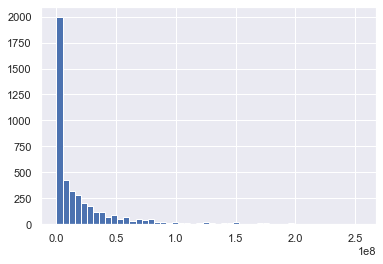

In [101]:
#Data Preprocessing & Distribtuion of Target Metric
na_target = data_raw[data_raw['clipped_budget'].isna()]
if na_target.shape[0]>=0:
    print(f'{na_target.shape[0]} records in data where target is NA \n')
    data_raw = data_raw.dropna(axis = 0, subset=['clipped_budget'])        
    %matplotlib inline
    data_raw['clipped_budget'].hist(bins=50)
    plt.show()

0 records in data where target is NA 



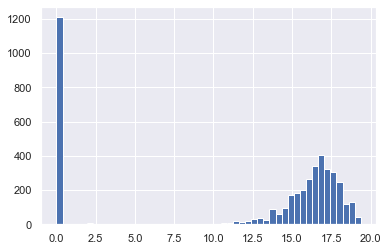

In [102]:
#Data Preprocessing & Distribtuion of Target Metric
data_raw['log_budget'] = np.log1p(data_raw['budget'])

na_target = data_raw[data_raw['log_budget'].isna()]
if na_target.shape[0]>=0:
    print(f'{na_target.shape[0]} records in data where target is NA \n')
    data_raw = data_raw.dropna(axis = 0, subset=['log_budget'])        
    %matplotlib inline
    data_raw['log_budget'].hist(bins=50)
    plt.show()

In [103]:
data_raw[['budget', 'clipped_budget','log_budget']].describe()

,budget,clipped_budget,log_budget
count,4.397000e+03,4.397000e+03,4397.000000
mean,2.265444e+07,2.251923e+07,11.783922
std,3.690253e+07,3.637335e+07,7.480174
min,0.000000e+00,0.000000e+00,0.000000
25%,0.000000e+00,2.000000e+05,0.000000
50%,7.500000e+06,7.500000e+06,15.830414
75%,2.800000e+07,2.800000e+07,17.147715
max,2.600000e+08,2.549000e+08,19.376192


In [104]:
if script_run in ['retrain','retrain_with_gridsearch']:
    # Set up the axes with gridspec
    fig = plt.figure(figsize=(50, 15))
    grid = plt.GridSpec(3, 3, hspace=0.2, wspace=0.2)
    budget_plt = fig.add_subplot(grid[0,1])
    clipped_budget_plt = fig.add_subplot(grid[1, 1], xticklabels=[])
    log_budget_plt = fig.add_subplot(grid[2, 1], yticklabels=[])

    # scatter points on the Budget axes
    budget_plt.scatter(x=data_raw['budget'], y=data_raw['revenue'])
    budget_plt.set_title('Relation between Budget and Revenue earned')
    plt.xlabel('Budget')
    plt.ylabel('Revenue')

    # scatter points on the Clipped Budget axes
    clipped_budget_plt.scatter(x=data_raw['clipped_budget'], y=data_raw['revenue'])
    clipped_budget_plt.set_title('Relation between Clipped Budget and Revenue earned')
    plt.xlabel('Clipped Budget')
    plt.ylabel('Revenue')

    # scatter points on the Log Budget axes
    log_budget_plt.scatter(x=data_raw['log_budget'], y=data_raw['revenue'])
    log_budget_plt.set_title('Relation between Log Budget and Revenue earned')
    plt.xlabel('Log Budget')
    plt.ylabel('Revenue')

# Feature Profiling

# Data PreProcessing
1. Imputations
2. Smalls Binning for categorical
3. Update Data Types

In [105]:
data_raw.head()

,id,budget,genres,imdb_id,original_language,original_title,overview,popularity,poster_path,production_companies,...,status,tagline,title,keywords,cast,crew,date,week,clipped_budget,log_budget
0,3001,0,"[{'id': 12, 'name': 'Adventure'}, {'id': 16, '...",tt1226251,ja,ディアルガVSパルキアVSダークライ,Ash and friends (this time accompanied by newc...,3.851534,/tnftmLMemPLduW6MRyZE0ZUD19z.jpg,NaN,...,Released,Somewhere Between Time & Space... A Legend Is ...,Pokémon: The Rise of Darkrai,"[{'id': 11451, 'name': 'pok√©mon'}, {'id': 115...","[{'cast_id': 3, 'character': 'Tonio', 'credit_...","[{'credit_id': '52fe44e7c3a368484e03d683', 'de...",2007-07-14,104392,0.0,0.000000
1,3002,88000,"[{'id': 27, 'name': 'Horror'}, {'id': 878, 'na...",tt0051380,en,Attack of the 50 Foot Woman,When an abused wife grows to giant size becaus...,3.559789,/9MgBNBqlH1sG4yG2u4XkwI5CoJa.jpg,"[{'name': 'Woolner Brothers Pictures Inc.', 'i...",...,Released,A titanic beauty spreads a macabre wave of hor...,Attack of the 50 Foot Woman,"[{'id': 9748, 'name': 'revenge'}, {'id': 9951,...","[{'cast_id': 2, 'character': 'Nancy Fowler Arc...","[{'credit_id': '55807805c3a3685b1300060b', 'de...",2058-05-19,107036,88000.0,11.385103
2,3003,0,"[{'id': 35, 'name': 'Comedy'}, {'id': 10749, '...",tt0118556,en,Addicted to Love,Good-natured astronomer Sam is devastated when...,8.085194,/ed6nD7h9sbojSWY2qrnDcSvDFko.jpg,"[{'name': 'Warner Bros.', 'id': 6194}, {'name'...",...,Released,A Comedy About Lost Loves And Last Laughs,Addicted to Love,"[{'id': 931, 'name': 'jealousy'}, {'id': 9673,...","[{'cast_id': 11, 'character': 'Maggie', 'credi...","[{'credit_id': '52fe4330c3a36847f8041367', 'de...",1997-05-23,103865,730000.0,0.000000
3,3004,6800000,"[{'id': 18, 'name': 'Drama'}, {'id': 10752, 'n...",tt1255953,fr,Incendies,A mother's last wishes send twins Jeanne and S...,8.596012,/sEUG3qjxwHjxkzuO7plrRHhOZUH.jpg,"[{'name': 'TS Productions', 'id': 313}, {'name...",...,Released,The search began at the opening of their mothe...,Incendies,"[{'id': 378, 'name': 'prison'}, {'id': 539, 'n...","[{'cast_id': 6, 'character': 'Nawal', 'credit_...","[{'credit_id': '56478092c3a36826140043af', 'de...",2010-09-04,104555,6800000.0,15.732433
4,3005,2000000,"[{'id': 36, 'name': 'History'}, {'id': 99, 'na...",tt0418753,en,Inside Deep Throat,"In 1972, a seemingly typical shoestring budget...",3.217680,/n4WC3zbelz6SG7rhkWbf8m9pMHB.jpg,NaN,...,Released,It was filmed in 6 days for 25 thousand dollar...,Inside Deep Throat,"[{'id': 279, 'name': 'usa'}, {'id': 1228, 'nam...","[{'cast_id': 1, 'character': 'Narrator (voice)...","[{'credit_id': '52fe44ce9251416c75041967', 'de...",2005-02-11,104266,2000000.0,14.508658


### Feature: *Genres*

In [106]:
j = 0
data_raw['genre_Count'] = 0
for i in data_raw['genres']:
    d = get_dict(i)
    if d != {}:
        
        data_raw['genre_Count'][j] = len(d)
    else:
        data_raw['genre_Count'][j] = 0 
    j += 1
data_raw.drop(['genres'], axis=1, inplace=True)

<ipython-input-106-c05d837245d1>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_raw['genre_Count'][j] = len(d)
<ipython-input-106-c05d837245d1>:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_raw['genre_Count'][j] = 0


### Feature: *Original_language*

C:\Users\simranpal.kohli\Anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='original_language', ylabel='count'>

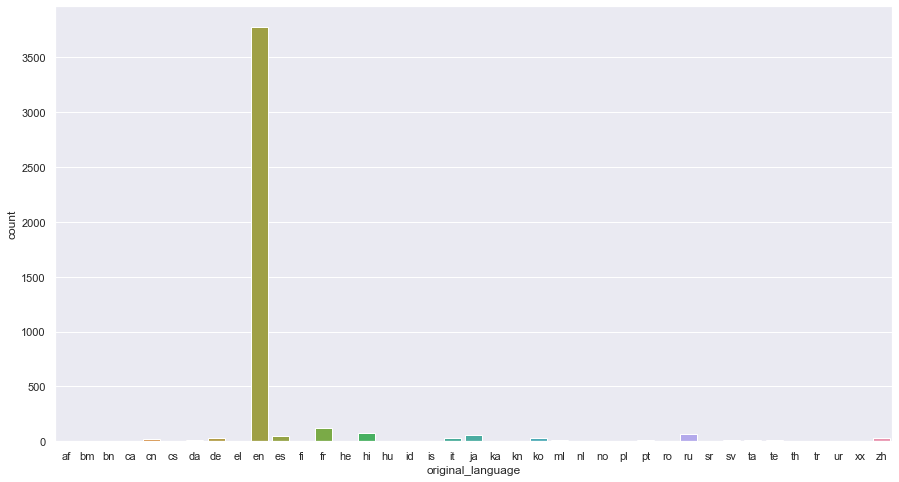

In [107]:
sns.set(rc = {'figure.figsize':(15,8)})
sns.countplot(data_raw['original_language'].sort_values())

In [108]:
for i in data_raw['original_language']:
    if(i=='en'):
        data_raw['Has_En']=1
    else:
        data_raw['Has_En']=0
data_raw.drop(['original_language'], axis=1, inplace=True)

### Feature: *Popularity*

In [109]:
if script_run in ['retrain','retrain_with_gridsearch']:
    sns.set(rc = {'figure.figsize':(15,8)})
    plt.scatter('popularity','revenue',data=data_raw)
    plt.show()

### Feature: *production_companies*

In [110]:
num_production_companies=pd.DataFrame(columns=['num_production_companies'])
data_raw=pd.concat([data_raw,num_production_companies],axis=1)

j=0
for i in data_raw["production_companies"]:
    d=get_dict(i)
    if len(d)!=0:
        data_raw['num_production_companies'][j]=len(d)
    else:
        data_raw['num_production_companies'][j]=np.NaN
    j+=1
data_raw.drop(['production_companies'], axis=1, inplace=True)

<ipython-input-110-bcbbab10c2f9>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_raw['num_production_companies'][j]=np.NaN
<ipython-input-110-bcbbab10c2f9>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_raw['num_production_companies'][j]=len(d)


C:\Users\simranpal.kohli\Anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='num_production_companies', ylabel='count'>

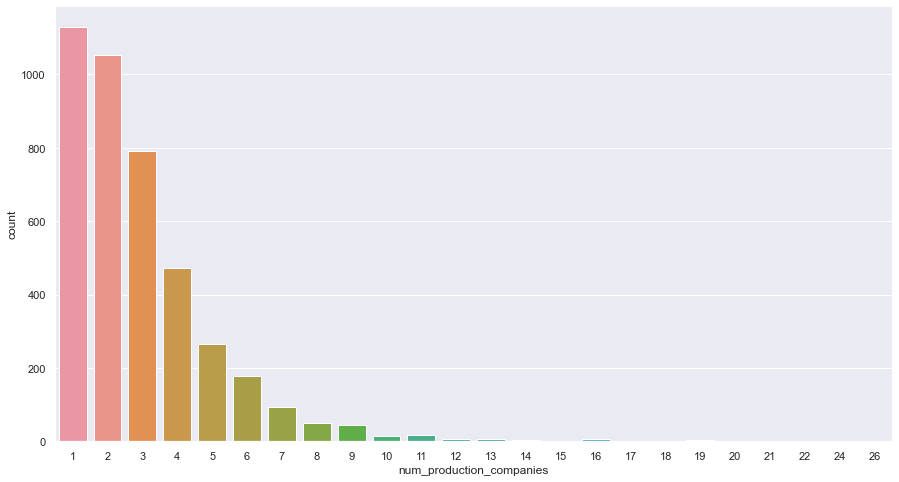

In [111]:
sns.countplot('num_production_companies',data=data_raw)

In [112]:
data_raw["num_production_companies"].isnull().sum()

258

In [113]:
data_raw['num_production_companies']=data_raw['num_production_companies'].fillna(data_raw['num_production_companies'].mean()).round()

### Feature: *production_countries*

In [114]:
prodect_countries=pd.DataFrame(columns=["production_country"])
data_raw=pd.concat([data_raw,prodect_countries],axis=1)

j = 0
for i in data_raw['production_countries']:
    d = get_dict(i)
    if d != {}:
        if len(d) > 1:
            countires = []
            for k in range(len(d)):
                countires.append(d[k]['name'])
            if 'United States of America' in countires:
                data_raw['production_country'][j] = 'United States of America'
        else:
            data_raw['production_country'][j] = d[0]['name']
    else:
        data_raw['production_country'][j] = np.NaN
    j += 1


<ipython-input-114-b6cc52ec04b6>:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_raw['production_country'][j] = 'United States of America'
<ipython-input-114-b6cc52ec04b6>:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_raw['production_country'][j] = d[0]['name']
<ipython-input-114-b6cc52ec04b6>:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_raw['production_country'][j] = np.NaN


In [115]:
is_use_preduction=pd.DataFrame(columns=["is_use_preduction"])
data_raw=pd.concat([data_raw,is_use_preduction],axis=1)

In [116]:
j=0
for i in data_raw["production_country"]:
    if i=='United States of America':
        data_raw['is_use_preduction'][j]=1
    elif str(i)=='NaN':
        data_raw['is_use_preduction'][j]=np.NaN
    else:
        data_raw['is_use_preduction'][j]=0
    j+=1
data_raw.drop(['production_countries','production_country'], axis=1, inplace=True)

<ipython-input-116-965759e72169>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_raw['is_use_preduction'][j]=1
<ipython-input-116-965759e72169>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_raw['is_use_preduction'][j]=0


In [117]:
data_raw['is_use_preduction'].isnull().sum()

1

### Feature: *release_data*

In [118]:
data_raw["release_year"] = pd.to_datetime(data_raw["release_date"]).dt.year.astype(int)
data_raw["release_day"] = pd.to_datetime(data_raw["release_date"]).dt.dayofweek.astype(int)
data_raw["release_month"] = pd.to_datetime(data_raw["release_date"]).dt.month.astype(int)

In [119]:
def fix_date(x):
    if x > 2022:
        return x - 100
    else:
        return x 

data_raw['release_year'] = data_raw['release_year'].apply(lambda x: fix_date(x))

In [120]:
if script_run in ['retrain','retrain_with_gridsearch']:
    sns.catplot(x='release_day',y='revenue',data=data_raw)

In [121]:
if script_run in ['retrain','retrain_with_gridsearch']:
    sns.catplot(x='release_month',y='revenue',data=data_raw)

(array([  13.,   31.,   33.,   67.,  110.,  251.,  613.,  890., 1579.,
         810.]),
 array([1923. , 1932.9, 1942.8, 1952.7, 1962.6, 1972.5, 1982.4, 1992.3,
        2002.2, 2012.1, 2022. ]),
 <BarContainer object of 10 artists>)

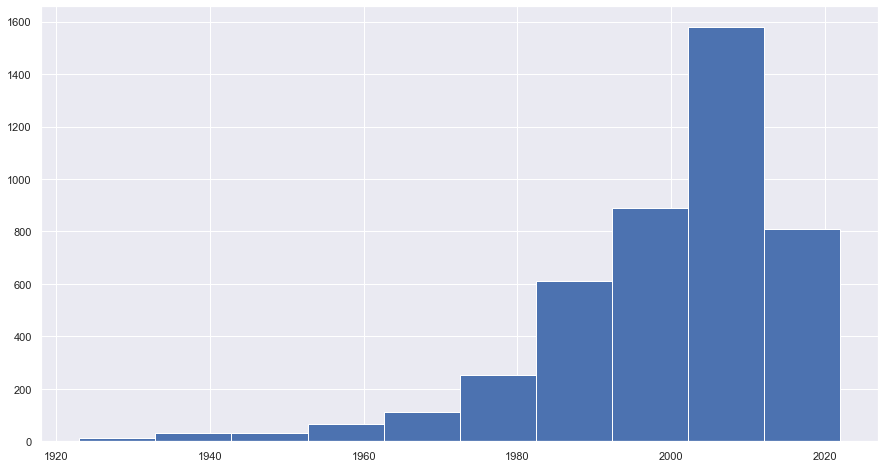

In [122]:
plt.hist('release_year',data=data_raw)

### Feature: *runtime*

In [123]:
data_raw['runtime'].isnull().sum()

4

In [124]:
data_raw['runtime']=data_raw['runtime'].fillna(data_raw['runtime'].mean()).round()

In [125]:
if script_run in ['retrain','retrain_with_gridsearch']:
    plt.subplots(figsize=(12, 9))
    plt.scatter('runtime','revenue',data=data_raw)

In [126]:
data_raw.head()

,id,budget,imdb_id,original_title,overview,popularity,poster_path,release_date,runtime,spoken_languages,...,week,clipped_budget,log_budget,genre_Count,Has_En,num_production_companies,is_use_preduction,release_year,release_day,release_month
0,3001,0,tt1226251,ディアルガVSパルキアVSダークライ,Ash and friends (this time accompanied by newc...,3.851534,/tnftmLMemPLduW6MRyZE0ZUD19z.jpg,2007-07-14,90.0,"[{'iso_639_1': 'en', 'name': 'English'}, {'iso...",...,104392,0.0,0.000000,4,0,3.0,1,2007,5,7
1,3002,88000,tt0051380,Attack of the 50 Foot Woman,When an abused wife grows to giant size becaus...,3.559789,/9MgBNBqlH1sG4yG2u4XkwI5CoJa.jpg,2058-05-19,65.0,"[{'iso_639_1': 'en', 'name': 'English'}]",...,107036,88000.0,11.385103,2,0,1.0,1,1958,6,5
2,3003,0,tt0118556,Addicted to Love,Good-natured astronomer Sam is devastated when...,8.085194,/ed6nD7h9sbojSWY2qrnDcSvDFko.jpg,1997-05-23,100.0,"[{'iso_639_1': 'en', 'name': 'English'}]",...,103865,730000.0,0.000000,2,0,3.0,1,1997,4,5
3,3004,6800000,tt1255953,Incendies,A mother's last wishes send twins Jeanne and S...,8.596012,/sEUG3qjxwHjxkzuO7plrRHhOZUH.jpg,2010-09-04,130.0,"[{'iso_639_1': 'fr', 'name': 'Français'}, {'is...",...,104555,6800000.0,15.732433,3,0,3.0,0,2010,5,9
4,3005,2000000,tt0418753,Inside Deep Throat,"In 1972, a seemingly typical shoestring budget...",3.217680,/n4WC3zbelz6SG7rhkWbf8m9pMHB.jpg,2005-02-11,92.0,"[{'iso_639_1': 'en', 'name': 'English'}]",...,104266,2000000.0,14.508658,2,0,3.0,1,2005,4,2


### Feature: *spoken_languages*

In [127]:
number_of_spoken_languages = pd.DataFrame(columns=['number_of_spoken_languages'])
data_raw = pd.concat([data_raw, number_of_spoken_languages], axis=1)

j = 0
for i in data_raw['spoken_languages']:
    d = get_dict(i)
    if d != {}:
        data_raw['number_of_spoken_languages'][j] = len(d)
    else:
        data_raw['number_of_spoken_languages'][j] = np.NaN
    j += 1


<ipython-input-127-e9abc9097c98>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_raw['number_of_spoken_languages'][j] = len(d)
<ipython-input-127-e9abc9097c98>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_raw['number_of_spoken_languages'][j] = np.NaN


In [128]:
if script_run in ['retrain','retrain_with_gridsearch']:
    sns.catplot(x='number_of_spoken_languages', y='revenue', data=data_raw)

In [129]:
data_raw["number_of_spoken_languages"].isnull().sum()

42

In [130]:
data_raw['number_of_spoken_languages']=data_raw['number_of_spoken_languages'].fillna(data_raw['number_of_spoken_languages'].mean()).round()
data_raw.drop(['spoken_languages'], axis=1, inplace=True)

### Feature: *status*

In [131]:
data_raw['status'].value_counts()

Released           4389
Post Production       5
Rumored               2
Name: status, dtype: int64

In [132]:
Status=pd.DataFrame(columns=["Status"])
data_raw=pd.concat([data_raw,Status],axis=1)

j=0
for i in data_raw["status"]:
    if i=='Released':
        data_raw['Status'][j]=1
    elif str(i)=='NaN':
        data_raw['Status'][j]=np.NaN
    else:
        data_raw['Status'][j]=0
    j+=1
data_raw.drop(['status'], axis=1, inplace=True)

<ipython-input-132-aa667aed68bb>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_raw['Status'][j]=1
<ipython-input-132-aa667aed68bb>:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_raw['Status'][j]=0


In [133]:
if script_run in ['retrain','retrain_with_gridsearch']:
    sns.catplot(x="Status",y="revenue",data=data_raw)

In [134]:
data_raw.drop(['Status'], axis=1, inplace=True)

### Feature: *tagline*

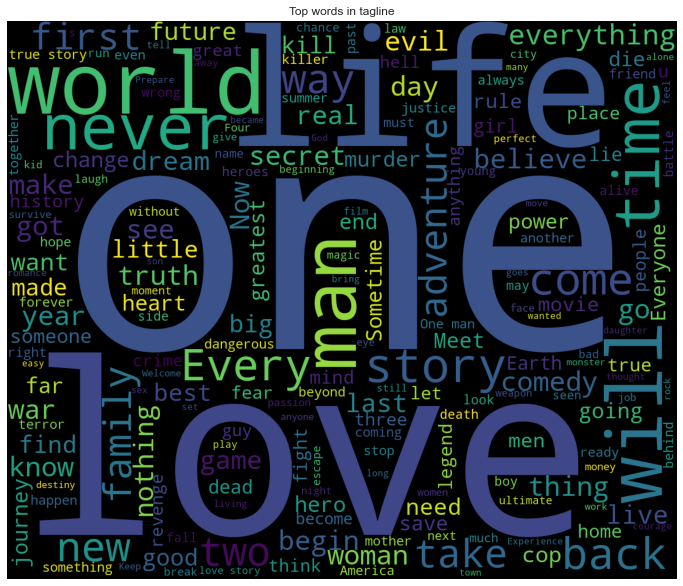

In [135]:
plt.figure(figsize = (12, 12))
text = ' '.join(data_raw['tagline'].fillna('').values)
wordcloud = WordCloud(max_font_size=None, background_color='black', width=1200, height=1000).generate(text)
plt.imshow(wordcloud)
plt.title('Top words in tagline')
plt.axis("off")
plt.show()

In [136]:
data_raw.drop(['title','release_date','tagline','date'], axis=1, inplace=True)

##  We can conclude that most films contains comedy, drama related words.

### Feature: *cast*

In [137]:
size_of_cast = pd.DataFrame(columns=['size_of_cast'])
data_raw = pd.concat([data_raw, size_of_cast], axis=1)

j = 0
for i in data_raw['cast']:
    d = get_dict(i)
    if d != {}:
        data_raw['size_of_cast'][j] = len(d)
    else:
        data_raw['size_of_cast'][j] = np.NaN
    j += 1
    
data_raw.drop(['cast'], axis=1, inplace=True)

<ipython-input-137-f7d77dd35ab0>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_raw['size_of_cast'][j] = len(d)
<ipython-input-137-f7d77dd35ab0>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_raw['size_of_cast'][j] = np.NaN


In [138]:
data_raw["size_of_cast"].isnull().sum()

14

In [139]:
data_raw['size_of_cast']=data_raw['size_of_cast'].fillna(data_raw['size_of_cast'].mean()).round()

In [140]:
if script_run in ['retrain','retrain_with_gridsearch']:
    plt.scatter("size_of_cast","revenue",data=data_raw)

### Drop Features with No importance

In [141]:
features_to_remove_ls = ['poster_path','imdb_id','original_title','overview','keywords','crew','budget']
data_raw.drop(features_to_remove_ls, axis=1, inplace=True)

In [142]:
NULLsRecords = data_raw.isnull().sum(axis=0)
print(NULLsRecords[NULLsRecords>0])
max(NULLsRecords)

is_use_preduction    1
dtype: int64


1

In [143]:
data_raw.head()

,id,popularity,runtime,week,clipped_budget,log_budget,genre_Count,Has_En,num_production_companies,is_use_preduction,release_year,release_day,release_month,number_of_spoken_languages,size_of_cast
0,3001,3.851534,90.0,104392,0.0,0.000000,4,0,3.0,1,2007,5,7,2.0,7.0
1,3002,3.559789,65.0,107036,88000.0,11.385103,2,0,1.0,1,1958,6,5,1.0,10.0
2,3003,8.085194,100.0,103865,730000.0,0.000000,2,0,3.0,1,1997,4,5,1.0,9.0
3,3004,8.596012,130.0,104555,6800000.0,15.732433,3,0,3.0,0,2010,5,9,3.0,23.0
4,3005,3.217680,92.0,104266,2000000.0,14.508658,2,0,3.0,1,2005,4,2,1.0,4.0


# Feature Correlation

In [144]:
if script_run in ['retrain','retrain_with_gridsearch']:
    corr =data_raw.corr()
    top_feature = corr.index[abs(corr['revenue'])>0.2]
    #Correlation plot
    plt.subplots(figsize=(12, 8))
    top_corr = data_raw[top_feature].corr()
    sns.heatmap(top_corr,cmap='Blues', annot=True)
    plt.show()

In [145]:
os.getcwd()

'C:\\Users\\simranpal.kohli\\AAAAAfiniti\\Personal\\Self_Study\\Projectzzz\\Hashmeet_Friend\\Aman_Project\\Churn_Model'

In [146]:
if script_run in ['retrain','retrain_with_gridsearch']:
    Data_Files_ls = os.listdir(f'{os.getcwd()}/{program_name}/Results')
    for f in Data_Files_ls:
        if not f.startswith('.'):
            shutil.move(f'{os.getcwd()}/{program_name}/Results/{f}',f'{os.getcwd()}/{program_name}/Results_Old/{f}')

In [147]:
os.chdir(os.getcwd()+'/'+program_name+'/Results')
%pwd

'C:\\Users\\simranpal.kohli\\AAAAAfiniti\\Personal\\Self_Study\\Projectzzz\\Hashmeet_Friend\\Aman_Project\\Churn_Model\\Box3d\\Results'

# Feature Profiling

In [148]:
continuous_type_ls = ['float16', 'float32', 'int16', 'int8','int64','float64','int32']
categorical_type_ls = ['object','category','UInt32']
trigger_cont_val = 0
trigger_cat_val = 0

cat_attribs = []
num_attribs =[]

for col in tqdm(data_raw.columns):
    if str(data_raw[col].dtype) in continuous_type_ls and trigger_cont_val<=15:
        num_attribs.append(col)
        trigger_cont_val = trigger_cont_val + 1
    if str(data_raw[col].dtype) in categorical_type_ls and trigger_cat_val<=15:
        cat_attribs.append(col)
        trigger_cat_val = trigger_cat_val + 1
print(num_attribs)
print(cat_attribs)

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 7602.05it/s]

['id', 'popularity', 'runtime', 'clipped_budget', 'log_budget', 'genre_Count', 'Has_En', 'num_production_companies', 'release_year', 'release_day', 'release_month', 'number_of_spoken_languages', 'size_of_cast']
['week', 'is_use_preduction']


In [149]:
num_ls = [i for i in num_attribs if i not in ['release_month','id']]
cat_ls = [i for i in cat_attribs if i not in ['release_month','id']]
print(num_ls)
print(cat_ls)

['popularity', 'runtime', 'clipped_budget', 'log_budget', 'genre_Count', 'Has_En', 'num_production_companies', 'release_year', 'release_day', 'number_of_spoken_languages', 'size_of_cast']
['week', 'is_use_preduction']


2it [00:00,  2.63it/s]


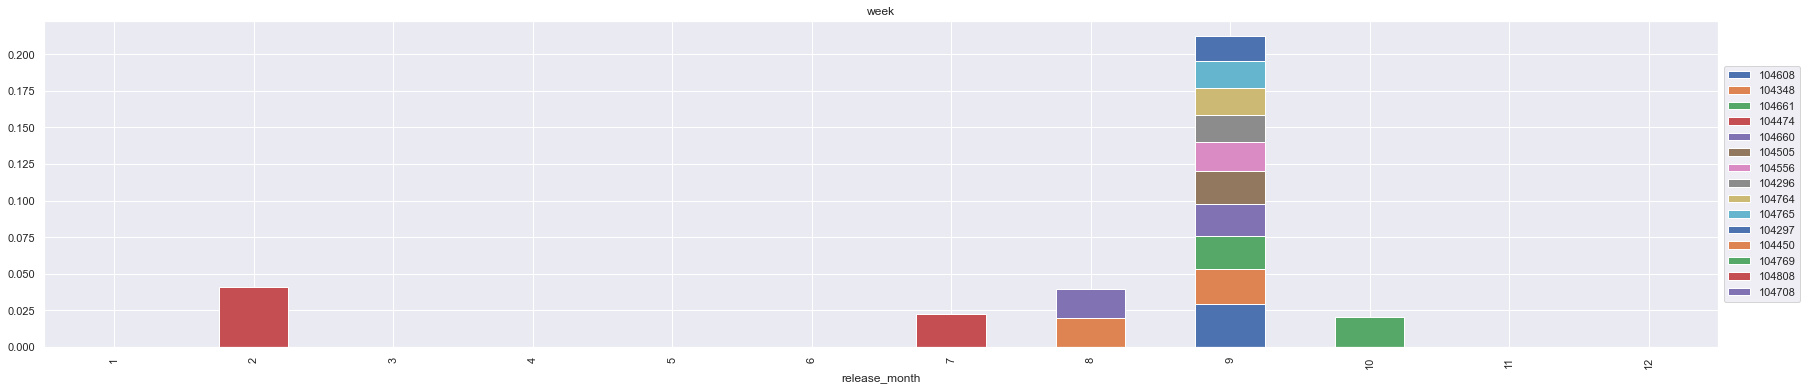

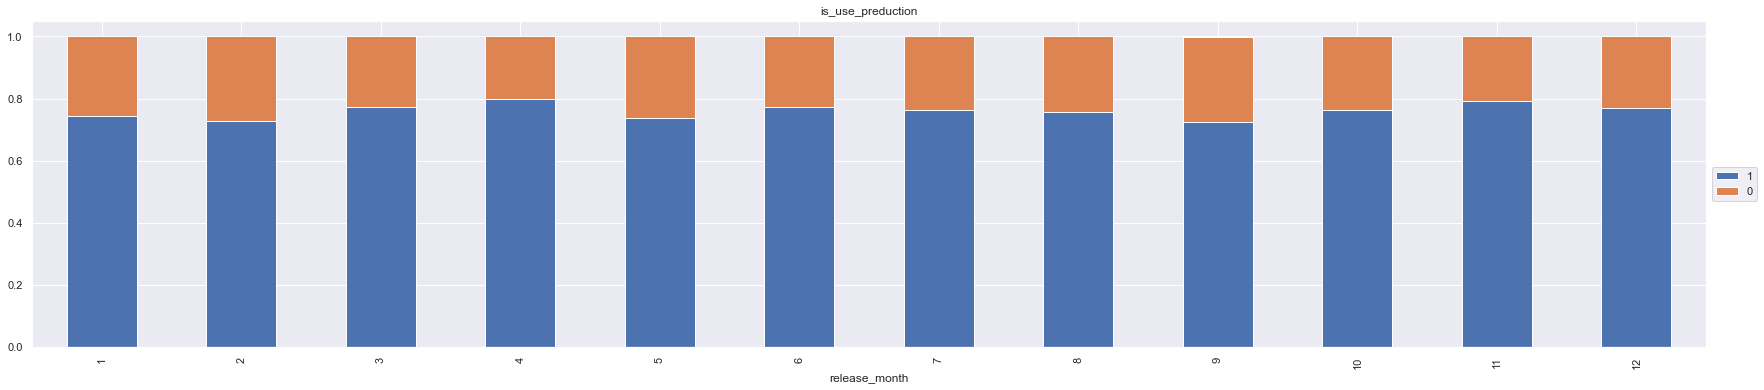

In [150]:
# categorical feature distributions

visual_train = data_raw.copy()
cat_report_pdf = PdfPages(f"Categorical_feature_profiling.pdf")
for i, col in tqdm(enumerate(cat_ls)):
    fig, axes = plt.subplots(1,1,sharey=False)
    fig.set_figheight(6)
    fig.set_figwidth(30)
    col_list = visual_train[col].value_counts(1).head(15).index
    a = (visual_train.groupby(['release_month',col])['release_month'].count()/visual_train.groupby(['release_month'])['release_month'].count()).unstack()[col_list].plot(kind='bar',stacked=True, ax=axes)
    axes.set_title(col)
    axes.legend(loc='center left',bbox_to_anchor=(1,0.5))
    cat_report_pdf.savefig(fig)
cat_report_pdf.close()

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 11/11 [00:01<00:00,  7.65it/s]


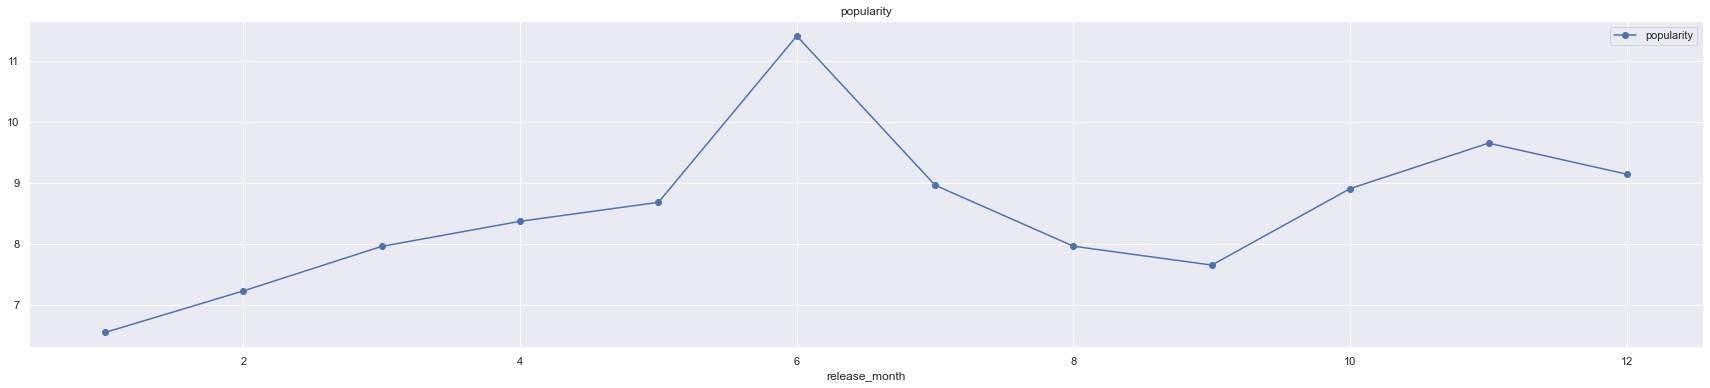

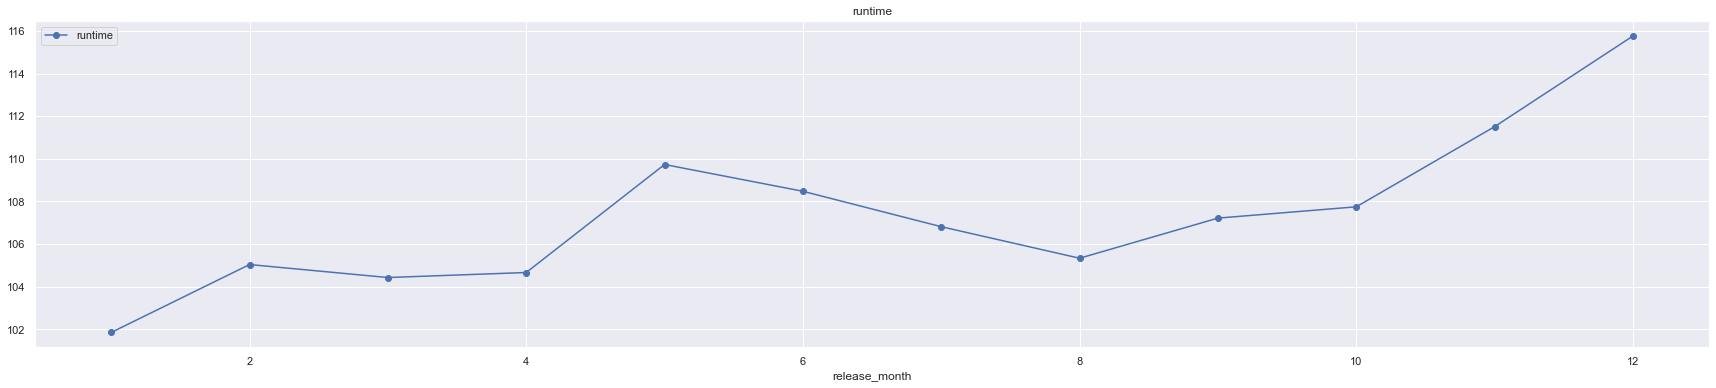

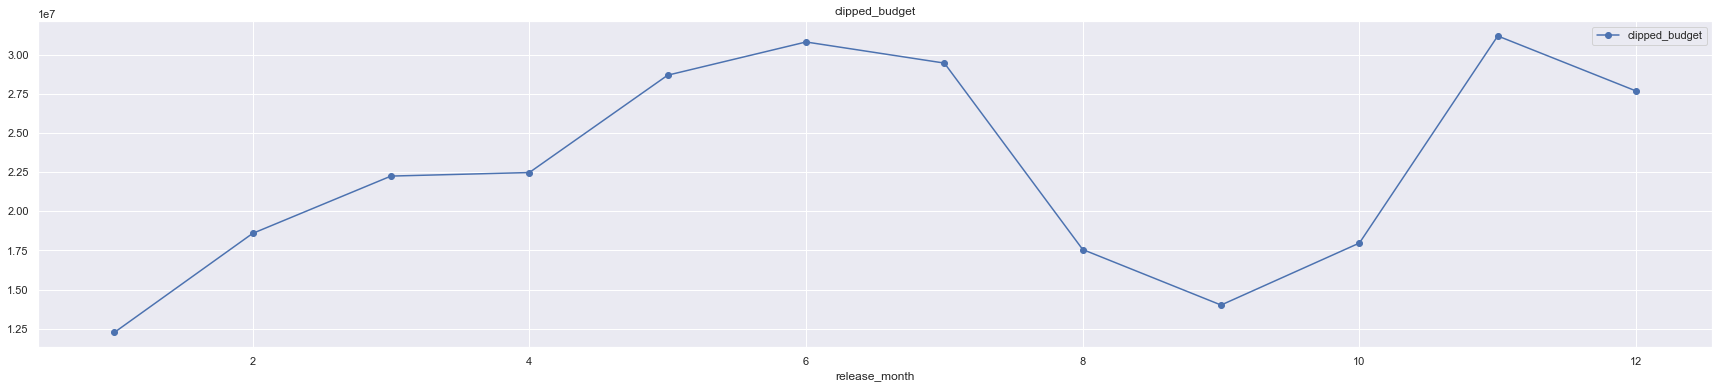

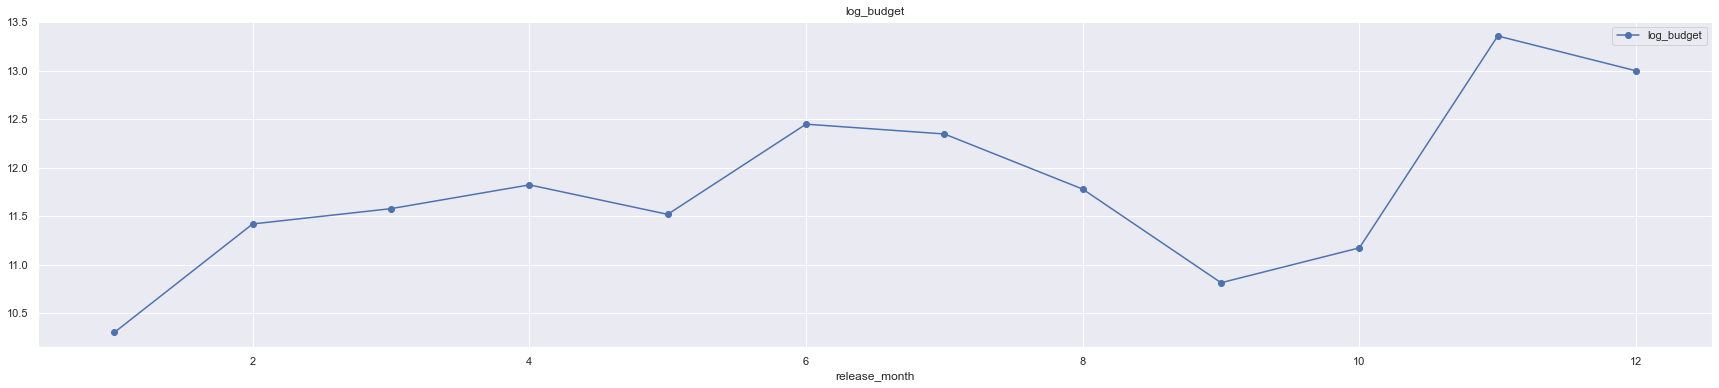

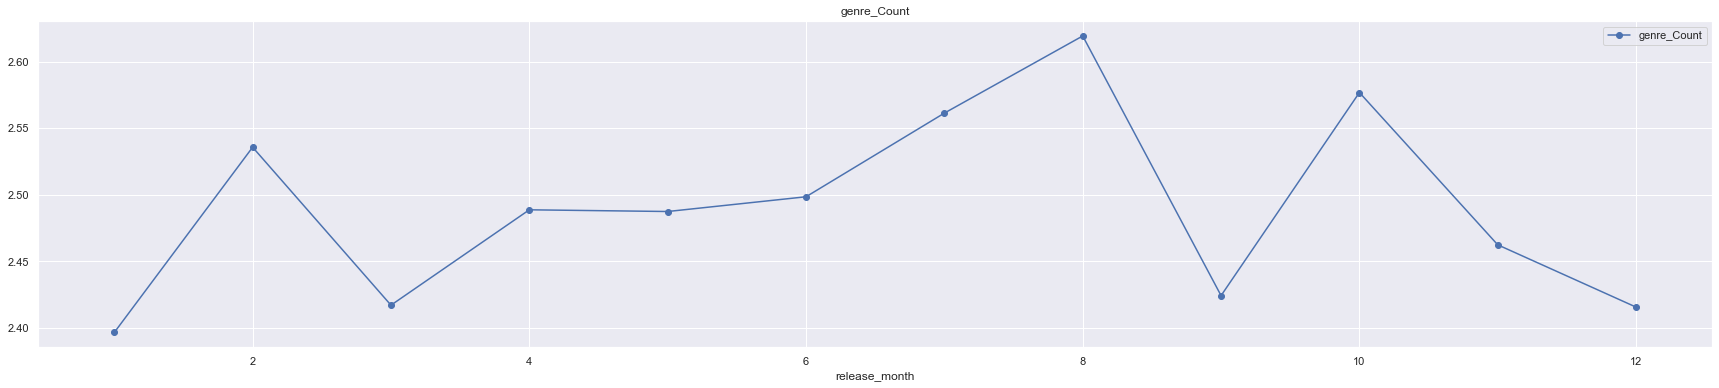

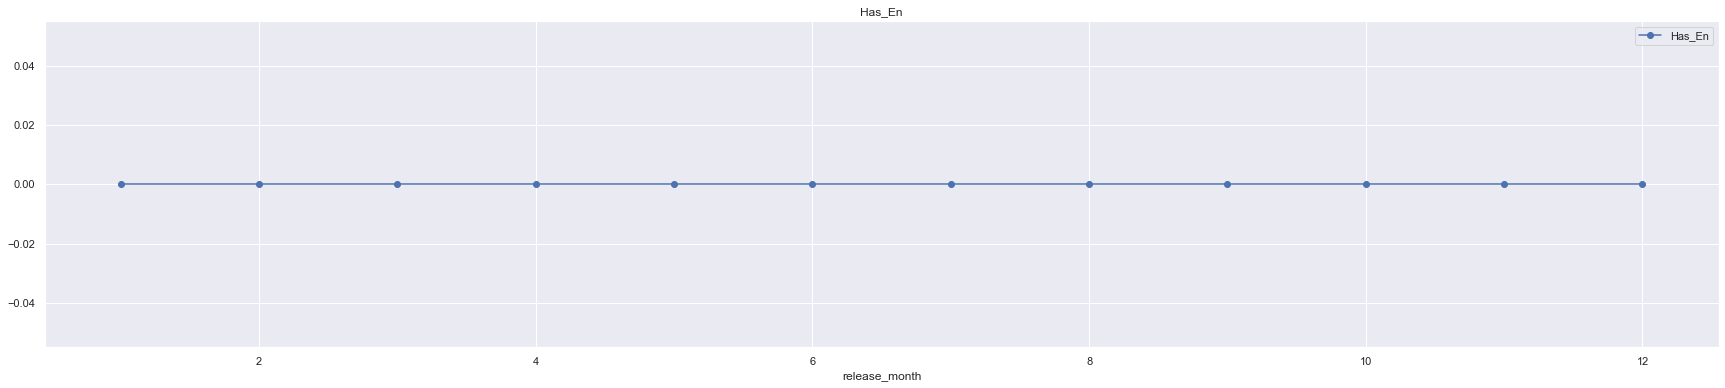

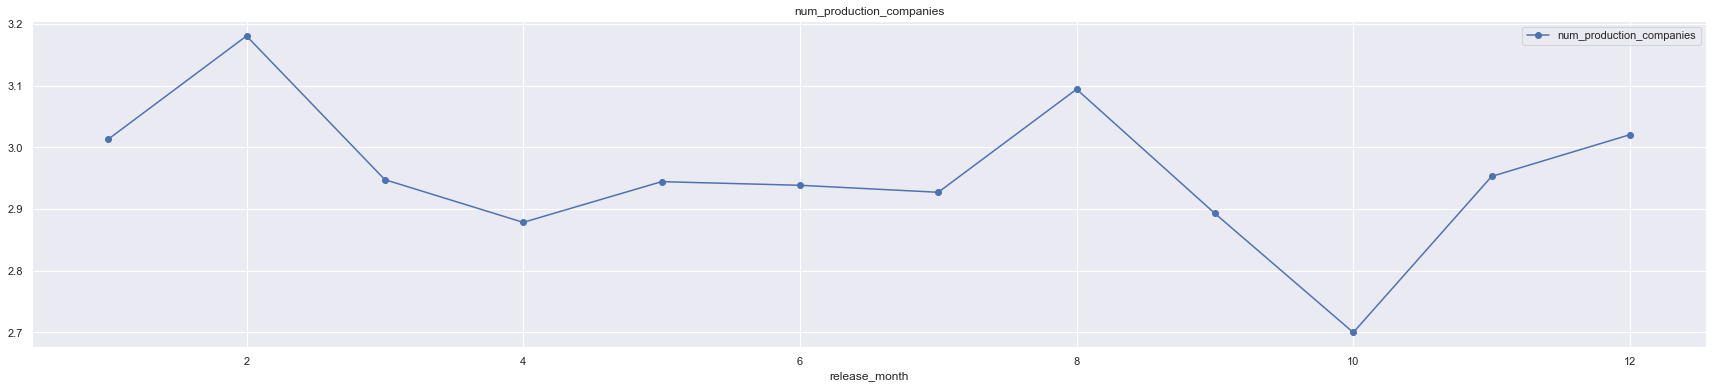

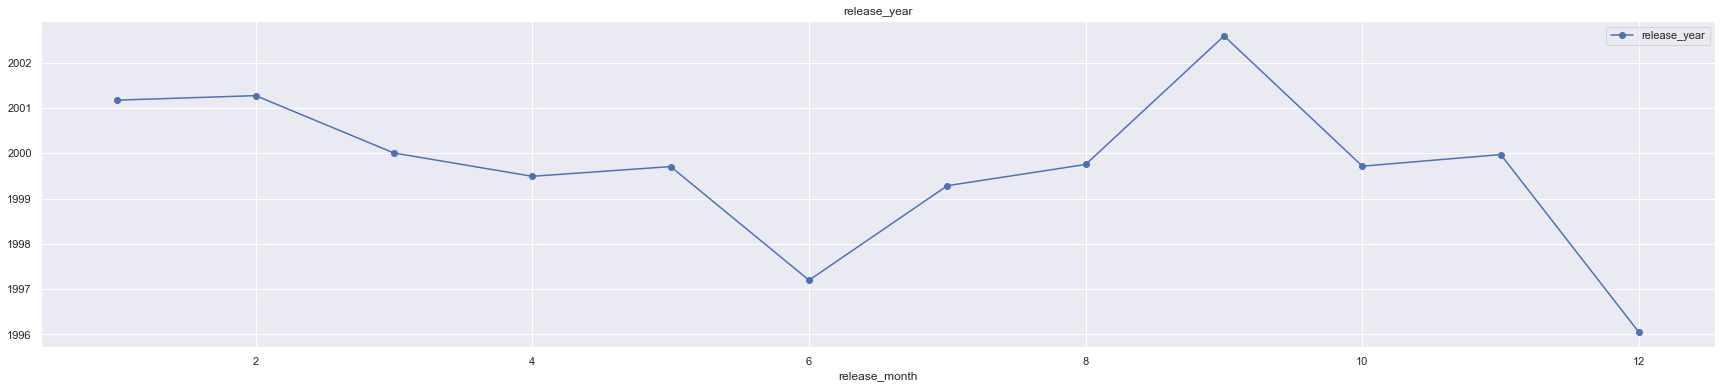

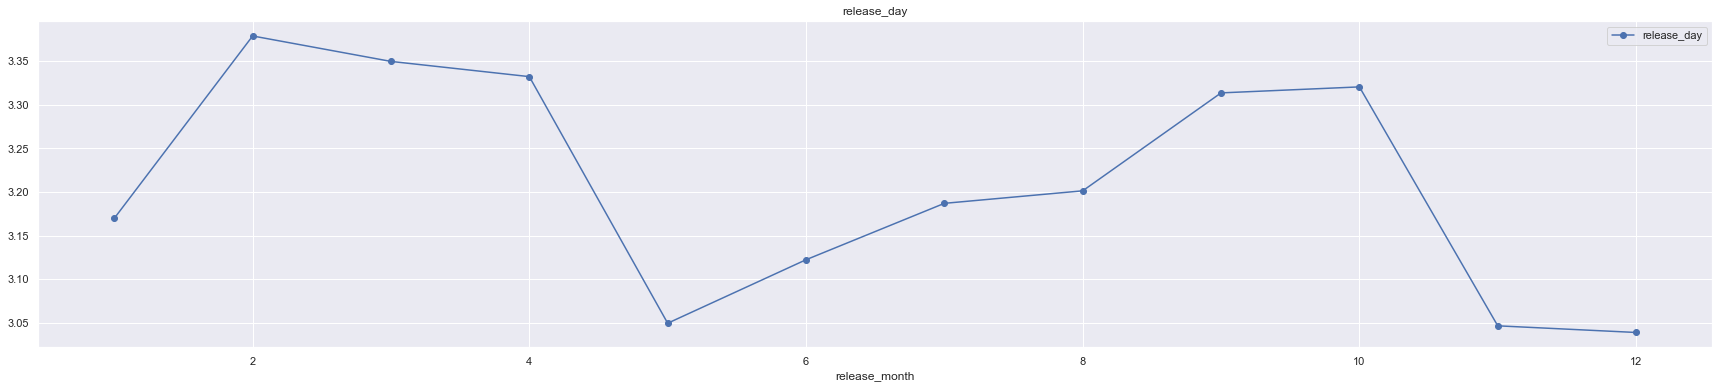

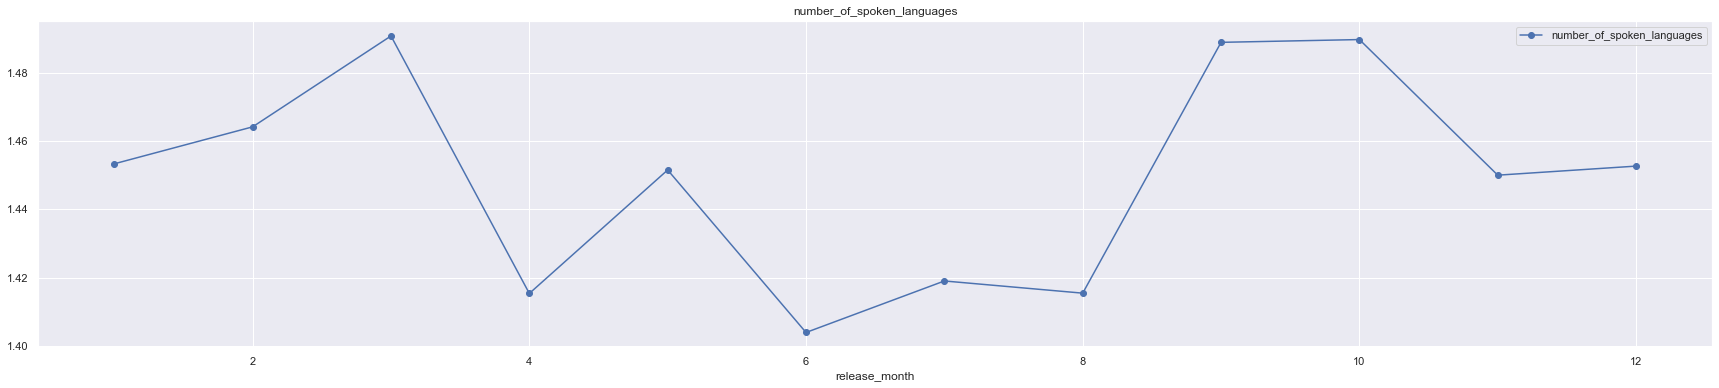

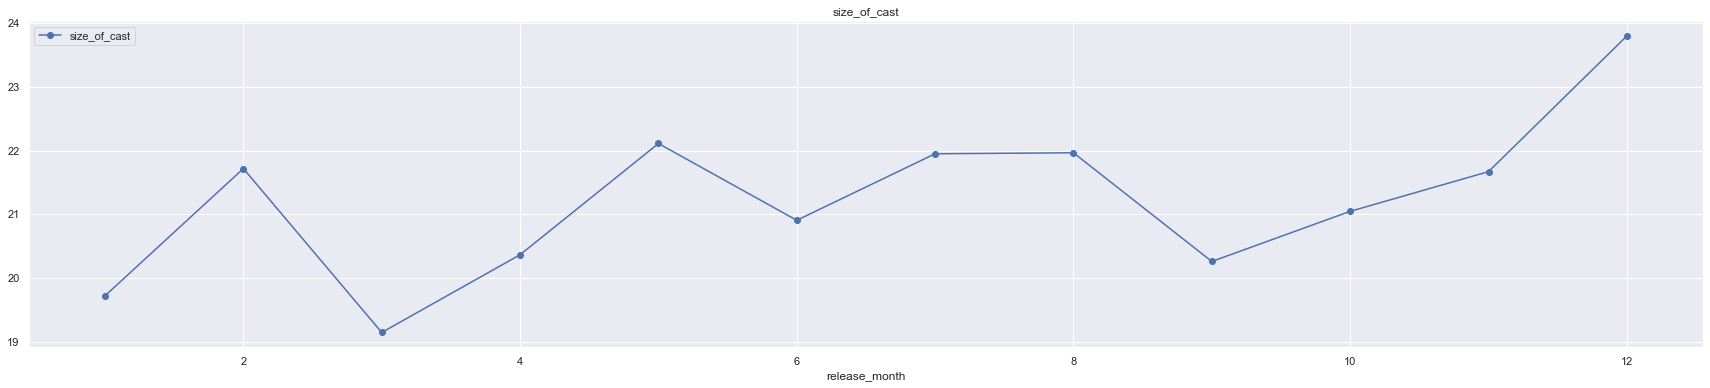

In [151]:
# continuous feature averages plots

cont_report_pdf = PdfPages(f"Continuous_feature_profiling.pdf")
for col in tqdm(num_ls):
    train_plot = visual_train[['release_month',col]].groupby(['release_month']).mean()
    fig, axes = plt.subplots(1,1,sharey=False)
    fig.set_figheight(6)
    fig.set_figwidth(30)
    a = train_plot.plot(title=col, ax=axes, marker = 'o')  
    cont_report_pdf.savefig(fig)
cont_report_pdf.close()

In [152]:
all_features_without_target_ls = [i for i in num_attribs + cat_attribs if i not in [target,'id']]
all_features_without_target_ls

['popularity',
 'runtime',
 'clipped_budget',
 'log_budget',
 'genre_Count',
 'Has_En',
 'num_production_companies',
 'release_year',
 'release_day',
 'release_month',
 'number_of_spoken_languages',
 'size_of_cast',
 'week',
 'is_use_preduction']

In [154]:
data_raw.columns

Index(['id', 'popularity', 'runtime', 'week', 'clipped_budget', 'log_budget',
       'genre_Count', 'Has_En', 'num_production_companies',
       'is_use_preduction', 'release_year', 'release_day', 'release_month',
       'number_of_spoken_languages', 'size_of_cast'],
      dtype='object')

In [153]:
# Random Forrest feature importance
if script_run in ['retrain_with_gridsearch','retrain']:
    clf = RandomForestRegressor(n_estimators=5000,min_samples_split=0.02, max_features=0.2, random_state=0, n_jobs=5, verbose = 1)
    clf.fit(data_raw[all_features_without_target_ls],data_raw[target])

    importances = clf.feature_importances_
    indices = np.argsort(importances)[::-1]

    values_ls = importances[indices]
    keys_ls = [all_features_without_target_ls[i] for i in indices]
    imp_feat_dict = dict(zip(keys_ls, values_ls))

    plt.figure()
    plt.title("Feature importances")

    plt.bar([all_features_without_target_ls[i] for i in indices], importances[indices],
           color="r", align="center")
    plt.xticks(rotation=90)
    plt.show()

NameError: name 'clf' is not defined

In [633]:
if script_run in ['retrain_with_gridsearch','retrain']:
    final_feat_dict = dict((k, v) for k, v in imp_feat_dict.items() if v >= 0.01)
    final_feat_ls = list(final_feat_dict.keys())
    print(final_feat_ls)

['clipped_budget', 'log_budget', 'popularity', 'size_of_cast', 'runtime', 'is_use_preduction', 'release_day', 'genre_Count', 'release_year', 'week', 'num_production_companies']


# Transform Training Data - imputer, scaling, encoding

In [635]:
if script_run in ['retrain_with_gridsearch','retrain']:
    
    cat_attribs_FI = []
    num_attribs_FI =[]
    trigger_cont_val = 0
    trigger_cat_val = 0
    
    for col in tqdm(final_feat_ls):
        if str(data_raw[col].dtype) in continuous_type_ls and trigger_cont_val<=15:
            num_attribs_FI.append(col)
            trigger_cont_val = trigger_cont_val + 1
        if str(data_raw[col].dtype) in categorical_type_ls and trigger_cat_val<=15:
            cat_attribs_FI.append(col)
            trigger_cat_val = trigger_cat_val + 1
    print(num_attribs_FI)
    print(cat_attribs_FI)

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 11/11 [00:00<00:00, 11037.64it/s]

['clipped_budget', 'log_budget', 'popularity', 'size_of_cast', 'runtime', 'release_day', 'genre_Count', 'release_year', 'num_production_companies']
['is_use_preduction', 'week']


In [636]:
#Pipeline - imputer, scaling, encoding
if script_run in ['retrain_with_gridsearch','retrain']:
    num_pipeline= Pipeline([
        ('Selector_num',DataFrameSelector(num_attribs_FI)),
        #('Imputer',SimpleImputer(strategy='median')),
        ('std_scalar', StandardScaler()),])

    cat_pipeline = Pipeline([
        ('Selector_cat',DataFrameSelector(cat_attribs_FI)),
        ('cat_encoder', OneHotEncoder(handle_unknown = 'ignore')),])

    full_pipeline = FeatureUnion(transformer_list=[
        ("num_pipeline",num_pipeline),
        ("cat_pipeline",cat_pipeline)
    ])

In [637]:
os.chdir('..')
%pwd

'C:\\Users\\simranpal.kohli\\AAAAAfiniti\\Personal\\Self_Study\\Projectzzz\\Hashmeet_Friend\\Aman_Project\\Churn_Model\\Box3d'

In [638]:
if script_run in ['retrain', 'retrain_with_gridsearch']:
    features_train = num_attribs_FI + cat_attribs_FI
    featurelist_file_name = f'{os.getcwd()}/Data_Files/{model_name}__featurelist.pkl'
    joblib.dump(features_train,featurelist_file_name, compress=1)
    old_file = featurelist_file_name
    new_file = f'{os.getcwd()}/Data_Files/{model_name_new}__featurelist.pkl'
    os.rename(old_file, new_file)
else:
    featurelist_file_name = f"{os.getcwd()}/Data_Files/{model_name}__featurelist.pkl"
    features_train = joblib.load(featurelist_file_name)

In [639]:
# if type_of_run != 'lookup':
#     X = data[features_train].copy()
#     Y = data[target].copy() 
    
if script_run in ['retrain_with_gridsearch','retrain']:
    X_train = data_raw[features_train].copy()
    Y_train = data_raw[target].copy() 
    X_train_prep = full_pipeline.fit_transform(X_train)
X = data_raw[features_train].copy()

# Feature Importance -  pick top K% features.

In [640]:
# Random Forrest feature importance
if script_run in ['retrain_with_gridsearch','retrain']:
    
    if(targettype == 'continuous'):
        clf = RandomForestRegressor(n_estimators=5000,min_samples_split=0.02, max_features=0.33, random_state=0, n_jobs=10, verbose = 1)
        clf.fit(X_train_prep,Y_train)

        importances = clf.feature_importances_
        cat_encoder = cat_pipeline.named_steps["cat_encoder"]
        cat_one_hot_attribs = list(cat_encoder.get_feature_names(cat_attribs_FI))
        attributes = num_attribs_FI + cat_one_hot_attribs

        importance_list = sorted(zip(importances,attributes), reverse=True)
        indices = np.argsort(importances)[::-1]
        sorted_importance = list(importances[indices])
        sorted_attributes = [attributes[i] for i in indices]
        sorted_importance = np.array(sorted_importance)
        threshold = np.percentile(sorted_importance,100-top_k)
        
        print(threshold)
        print('\n')
        
        index = [i for i,v in enumerate(importances) if v>threshold]
        print(index)
        print('\n')
        print(len(index))

[Parallel(n_jobs=10)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done  30 tasks      | elapsed:    0.0s
[Parallel(n_jobs=10)]: Done 180 tasks      | elapsed:    0.7s
[Parallel(n_jobs=10)]: Done 430 tasks      | elapsed:    1.7s
[Parallel(n_jobs=10)]: Done 780 tasks      | elapsed:    3.2s
[Parallel(n_jobs=10)]: Done 1230 tasks      | elapsed:    5.2s
[Parallel(n_jobs=10)]: Done 1780 tasks      | elapsed:    7.8s
[Parallel(n_jobs=10)]: Done 2430 tasks      | elapsed:   10.7s
[Parallel(n_jobs=10)]: Done 3180 tasks      | elapsed:   14.1s
[Parallel(n_jobs=10)]: Done 4030 tasks      | elapsed:   18.3s
[Parallel(n_jobs=10)]: Done 4980 tasks      | elapsed:   23.0s
[Parallel(n_jobs=10)]: Done 5000 out of 5000 | elapsed:   23.1s finished


3.222767679766574e-09


[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 14, 16, 18, 19, 22, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 39, 41, 42, 43, 44, 46, 47, 48, 49, 50, 51, 52, 53, 54, 56, 57, 58, 59, 60, 62, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 77, 78, 79, 81, 82, 83, 84, 86, 87, 88, 89, 90, 91, 92, 95, 96, 97, 99, 100, 101, 102, 103, 105, 106, 108, 109, 110, 113, 114, 115, 116, 118, 119, 120, 121, 122, 123, 127, 128, 129, 130, 131, 133, 134, 136, 137, 138, 140, 143, 144, 148, 149, 150, 151, 152, 156, 157, 158, 160, 161, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172, 173, 175, 176, 178, 179, 182, 183, 185, 186, 189, 190, 191, 192, 193, 194, 195, 196, 197, 202, 204, 205, 206, 207, 209, 210, 213, 214, 215, 216, 217, 218, 219, 221, 222, 223, 224, 225, 227, 228, 229, 230, 231, 232, 233, 234, 236, 237, 239, 240, 241, 242, 243, 244, 245, 246, 247, 248, 249, 250, 251, 252, 257, 258, 259, 260, 261, 262, 263, 265, 267, 269, 270, 271, 272, 273, 275, 276, 279, 280, 281, 282, 283,

In [641]:
if script_run in ['retrain_with_gridsearch','retrain']:
    full_pipeline_with_featureselection = Pipeline([
        ("data_prep",full_pipeline),
        ("feature_selection",TopFeatureSelector(importances,round(len(importances)*top_k/100)))])
    print(round(len(importances)*top_k/100))

1205


# Model Search 

In [642]:
%pwd

'C:\\Users\\simranpal.kohli\\AAAAAfiniti\\Personal\\Self_Study\\Projectzzz\\Hashmeet_Friend\\Aman_Project\\Churn_Model\\Box3d'

In [643]:
best_params = 'Empty'
if script_run in ['retrain_with_gridsearch']:
    X_train_prep = full_pipeline_with_featureselection.fit_transform(X_train)
    print(X_train_prep.shape)
    
    reg_gs = GridSearchCV(estimator=XGBRegressor(),
                      param_grid={"eta": (0.01,0.05,0.1,0.15),
                                  "max_depth": [4,8,10,11,13,16],
                                  "min_child_weight": [1],
                                  "gamma": [0.0, 0.3,0.5,0.7,0.9,1.1,1.3,1.5],
                                  "colsample_bytree": [0.3, 0.5,0.6, 0.7, 1.0],}, 
                       cv=5, scoring="neg_mean_squared_error", verbose=2, n_jobs=10)
    grid_result = reg_gs.fit(X_train_prep, Y_train)
    best_params = grid_result.best_params_
    #print(grid_result.cv_results_)
    print(grid_result.best_score_)
    print(best_params)
    joblib.dump(best_params,f'{os.getcwd()}/Data_Files/best_xgboost_{last_trained_model_date}.pkl', compress=1)
    
    old_file = os.path.join(f'{os.getcwd()}/Data_Files/',"best_xgboost_"+last_trained_model_date+".pkl")
    new_file = os.path.join(f'{os.getcwd()}/Data_Files/','best_xgboost_'+today_trained_model_date+".pkl")
    os.rename(old_file, new_file)
if script_run in ['retrain']:
    print('GS Skipped')
    best_params = joblib.load(f'{os.getcwd()}/Data_Files/best_xgboost_{last_trained_model_date}.pkl')
    old_file = os.path.join(f'{os.getcwd()}/Data_Files/',"best_xgboost_"+last_trained_model_date+".pkl")
    new_file = os.path.join(f'{os.getcwd()}/Data_Files/','best_xgboost_'+today_trained_model_date+".pkl")
    os.rename(old_file, new_file)
else:
    print('GS Skipped')
    best_params = joblib.load(f'{os.getcwd()}/Data_Files/best_xgboost_{last_trained_model_date}.pkl')
    print(best_params) 

GS Skipped


In [644]:
if script_run in ['retrain', 'retrain_with_gridsearch']:
    prep_predict_pipeline = Pipeline([
        ('prep_shortlist',full_pipeline_with_featureselection),
        ('xgb',XGBRegressor(**best_params))])
    prep_predict_pipeline.fit(X_train,Y_train)
    model_file_name = f'{os.getcwd()}/Data_Files/{model_name}__xgb_model.pkl'
    joblib.dump(prep_predict_pipeline,model_file_name, compress=1)
    old_file = model_file_name
    new_file = f'{os.getcwd()}/Data_Files/{model_name_new}__xgb_model.pkl'
    os.rename(old_file, new_file)
else:
    model_file_name = f'{os.getcwd()}/Data_Files/{model_name}__xgb_model.pkl'
    prep_predict_pipeline = joblib.load(model_file_name)

In [645]:
y_pred  = prep_predict_pipeline.predict(X)
y_pred = y_pred.round(1)
if script_run in ['retrain', 'retrain_with_gridsearch']:
    Y = data_raw[target]

60735676.41740986
0.8049154141211536


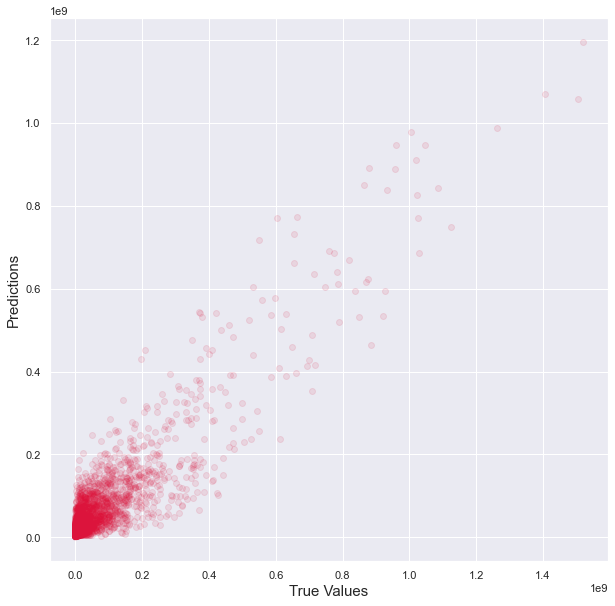

In [646]:
if script_run in ['retrain', 'retrain_with_gridsearch']:
    plt.figure(figsize=(10,10))
    plt.scatter(Y, y_pred, c='crimson',alpha=0.1)
    plt.xlabel('True Values', fontsize=15)
    plt.ylabel('Predictions', fontsize=15)
    print(np.sqrt(mean_squared_error(Y, y_pred)))
    print(r2_score(Y,y_pred))

In [647]:
u_ids = pd.DataFrame(data_raw[list(set(unique_identifier+['release_month']))])
pred  = pd.DataFrame(y_pred)
data_pred = pd.concat([u_ids.reset_index(drop = True), pred], axis = 1)
if script_run in ['retrain', 'retrain_with_gridsearch']:
    actual  = pd.DataFrame(Y)
    data_actual = pd.concat([u_ids.reset_index(drop = True), actual.reset_index(drop = True)], axis = 1)
    predictions = pd.merge(data_pred, data_actual, on =  ['id','release_month'], how = 'inner')
    predictions = predictions.rename(columns = {0:'prediction', target :'actual'})

In [648]:
os.chdir(os.getcwd()+'/Results')
%pwd

'C:\\Users\\simranpal.kohli\\AAAAAfiniti\\Personal\\Self_Study\\Projectzzz\\Hashmeet_Friend\\Aman_Project\\Churn_Model\\Box3d\\Results'

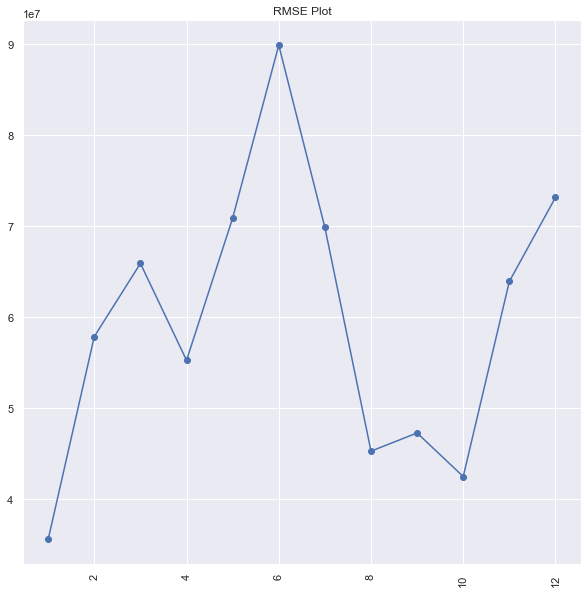

In [649]:
if script_run in ['retrain','retrain_with_gridsearch']:
    filename = script_run +"_Error_Plot_" + model_name_new +'.pdf'
    pdf = PdfPages(filename)    
    u_ids = pd.DataFrame(data_raw[list(set(unique_identifier+['release_month']))])
    pred  = pd.DataFrame(y_pred)
    actual  = pd.DataFrame(Y)

    predictions['inserted_date'] = pd.to_datetime('now')
    error = predictions.groupby(['release_month']).apply(lambda x: np.sqrt(mean_squared_error(x.actual,x.prediction))).reset_index()
    error.columns = ['release_month','rmse']
    fig_1 = plt.figure(figsize=(10,10))
    plt.plot(error['release_month'],error['rmse'],'-bo')
    plt.title('RMSE Plot')
    plt.xticks(rotation='90')
    pdf.savefig(fig_1)
    
    r2_sqr = predictions.groupby(['release_month']).apply(lambda x: np.sqrt(r2_score(x.actual,x.prediction))).reset_index()
    r2_sqr.columns = ['release_month','r2']
    fig_2 = plt.figure(figsize=(10,10))
    plt.plot(r2_sqr['release_month'],r2_sqr['r2'],'-bo')
    plt.title('R2 Square Plot')
    plt.xticks(rotation='90')
    pdf.savefig(fig_2)
    plt.close()
    pdf.close()
    
else:
    u_ids = pd.DataFrame(data_raw[list(set(unique_identifier+['release_month']))])
    pred  = pd.DataFrame(y_pred)
    predictions = pd.concat([u_ids,pred], axis=1)
    predictions.columns  = list(set(unique_identifier+['release_month']))+['prediction']
    predictions['inserted_date'] = pd.to_datetime('now')
    pred_raw_final = pd.merge(pred_raw, predictions, on =  ['id'], how = 'inner')
    filename_csv = script_run +'__'+ model_name + '_'+str(pd.to_datetime('now'))
    filename_csv = filename_csv.replace('.', '_').replace(' ','_').replace(':','_')
    filename_csv = filename_csv + '.csv'
    pred_raw_final.to_csv(filename_csv)

In [650]:
if script_run in ['retrain','retrain_with_gridsearch']:
    Zscores =stats.zscore(error['rmse'])
    indexes = (np.abs(Zscores)>2.0)
    anaomlousdays  = error[indexes]
    print(anaomlousdays)

   release_month          rmse
5              6  8.985418e+07


# Try & Test Models

In [651]:
# Rf_model=RandomForestRegressor(random_state=1)
# Rf_model.fit(train_x,y)
# Rf_prediction=Rf_model.predict(train_x)
# mean_absolute_error(Rf_prediction,y)

# r2_score(Rf_prediction,y)

# test_id=testData["id"]
# test_id.shape
# test_x=testData[features]
# Rf_predictions=Rf_model.predict(test_x)


# submission = pd.DataFrame({'id': test_id, 'revenue':Rf_predictions})
# submission = submission[['id', 'revenue']]

# submission.to_csv("submission.csv", index=False)